# Tutorial 2.1: Inputs, Files, and Scans

Before building a new MB-nrg path, we must first generate a variety of different files that will either be used as input for the PEF construction process or otherwise useful to us during the construction or validation of the PEF. In this notebook, we optimize our geometries, calculate their vibrational motions, make some 2- and 3-body scans and find some low-lying dimers, trimers, tetramers, and hexamers, and perform electronic structure calculations for all these geometries.

## 2.1.0 Imports and Paths

Execute the imports notebook:

In [2]:
%run Tutorial_2_Imports.ipynb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Execute the paths notebook:

In [3]:
%run Tutorial_2_Paths.ipynb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 2.1.1 Create `.def` definition files

MB-Fit uses `.def` files to store information about monomer or n-mer *types*. A monomer type is all the information about a monomer that does not depend on its structure and thus is common between all monomers of the same type. This includes atom elements, atom symmetries, and bonding topology. In MB-Fit, the information in a `.def` file is stored in an object called a `Defintition`.

Let's begin by creating the `Definitions` for the two fragments we will be working with.

First, CH$_3$-NH$_2$:

In [3]:
fragment_CH3NH2_definition = BasicFragmentDefinition()

CA  = fragment_CH3NH2_definition.add_atom(AtomDefinition("C", "A"))
HB1 = fragment_CH3NH2_definition.add_atom(AtomDefinition("H", "B"))
HB2 = fragment_CH3NH2_definition.add_atom(AtomDefinition("H", "B"))
HB3 = fragment_CH3NH2_definition.add_atom(AtomDefinition("H", "B"))
NC  = fragment_CH3NH2_definition.add_atom(AtomDefinition("N", "C"))
HD1 = fragment_CH3NH2_definition.add_atom(AtomDefinition("H", "D"))
HD2 = fragment_CH3NH2_definition.add_atom(AtomDefinition("H", "D"))

fragment_CH3NH2_definition.add_bond(CA, HB1, BondDefinition(BondType.SINGLE))
fragment_CH3NH2_definition.add_bond(CA, HB2, BondDefinition(BondType.SINGLE))
fragment_CH3NH2_definition.add_bond(CA, HB3, BondDefinition(BondType.SINGLE))
fragment_CH3NH2_definition.add_bond(CA, NC, BondDefinition(BondType.SINGLE))
fragment_CH3NH2_definition.add_bond(NC, HD1, BondDefinition(BondType.SINGLE))
fragment_CH3NH2_definition.add_bond(NC, HD2, BondDefinition(BondType.SINGLE))

write_fragment_definition(paths.definitions.fragments.CH3NH2, fragment_CH3NH2_definition)

Second, H$_2$O:

In [4]:
fragment_H2O_definition = BasicFragmentDefinition()
OE  = fragment_H2O_definition.add_atom(AtomDefinition("O", "E"))
HF1 = fragment_H2O_definition.add_atom(AtomDefinition("H", "F"))
HF2 = fragment_H2O_definition.add_atom(AtomDefinition("H", "F"))
fragment_H2O_definition.add_bond(OE, HF1, BondDefinition(BondType.SINGLE))
fragment_H2O_definition.add_bond(OE, HF2, BondDefinition(BondType.SINGLE))

write_fragment_definition(paths.definitions.fragments.H2O, fragment_H2O_definition)

Now let's make the `Definitions` for all the n-mers we will be working with:

First, the CH$_3$-NH$_2$ monomer, containing a single CH$_3$-NH$_2$ fragment:

In [5]:
definition_CH3NH2 = BasicCompoundDefinition()
definition_CH3NH2.add_fragment(fragment_CH3NH2_definition)

write_definition(paths.definitions.systems.CH3NH2, definition_CH3NH2)

Then, then H$_2$O monomer, containing a single H$_2$O fragment:

In [6]:
definition_H2O = BasicCompoundDefinition()
definition_H2O.add_fragment(fragment_H2O_definition)

write_definition(paths.definitions.systems.H2O, definition_H2O)

Next, the CH$_3$-NH$_2$ -- H$_2$O dimer, with two fragments:

In [7]:
definition_CH3NH2_H2O = BasicCompoundDefinition()
definition_CH3NH2_H2O.add_fragment(fragment_CH3NH2_definition)
definition_CH3NH2_H2O.add_fragment(fragment_H2O_definition)

write_definition(paths.definitions.systems.CH3NH2_H2O, definition_CH3NH2_H2O)

Fianlly, the CH$_3$-NH$_2$ -- H$_2$O -- H$_2$O trimer, with three fragments:

In [8]:
definition_CH3NH2_H2O_H2O = BasicCompoundDefinition()
definition_CH3NH2_H2O_H2O.add_fragment(fragment_CH3NH2_definition)
definition_CH3NH2_H2O_H2O.add_fragment(fragment_H2O_definition)
definition_CH3NH2_H2O_H2O.add_fragment(fragment_H2O_definition)

write_definition(paths.definitions.systems.CH3NH2_H2O_H2O, definition_CH3NH2_H2O_H2O)

While we will only build our PEF up to the 3-body level, we will also do some analysis on larger clusters, so we make definitions for those also.

The tetramer:

In [9]:
definition_tetramer = BasicCompoundDefinition()
definition_tetramer.add_fragment(fragment_CH3NH2_definition)
definition_tetramer.add_fragment(fragment_H2O_definition)
definition_tetramer.add_fragment(fragment_H2O_definition)
definition_tetramer.add_fragment(fragment_H2O_definition)

write_definition(paths.definitions.systems.tetramer, definition_tetramer)

And the pentamer:

In [10]:
definition_pentamer = BasicCompoundDefinition()
definition_pentamer.add_fragment(fragment_CH3NH2_definition)
definition_pentamer.add_fragment(fragment_H2O_definition)
definition_pentamer.add_fragment(fragment_H2O_definition)
definition_pentamer.add_fragment(fragment_H2O_definition)
definition_pentamer.add_fragment(fragment_H2O_definition)

write_definition(paths.definitions.systems.pentamer, definition_pentamer)

We've saved each `Definition` to a `.def` file, which we will read-in as needed throughout Tutorial 2.

## 2.1.2 Geometry Initialization

Next, we need a reasonable initial guess for the structure of our monomer. The guess need only be good enough that it will covnerge to the actual minimum structure when we perform a minimization with DFT. MB-Fit contains the class `VESPRInitializer`, which will make a reasonable guess about the structure of a molecule based on its bonding topology. Let's use `VESPRInitializer` to create an initial structure file:

In [11]:
system_initializer = VSEPRInitializer(seed=12345)

In [12]:
definition_CH3NH2 = read_definition(paths.definitions.systems.CH3NH2)
initialized_structure_CH3NH2 = system_initializer(definition_CH3NH2)
write_system(paths.structures.initialized_CH3NH2, initialized_structure_CH3NH2)

Initializing compound C1H3N1H2
System initialization complete!


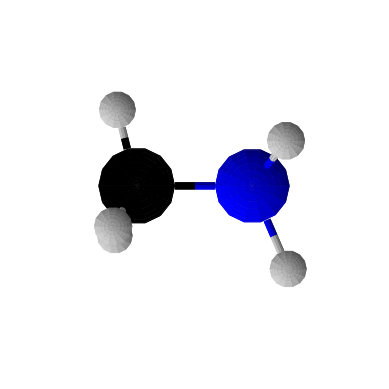

In [13]:
render_system(
        initialized_structure_CH3NH2,
        centerer=lambda system: system.atoms[0].point,
        aligner=lambda system: (system.atoms[4].point, system.atoms[3].point)
)

In [14]:
definition_H2O = read_definition(paths.definitions.systems.H2O)
initialized_structure_H2O = system_initializer(definition_H2O)
write_system(paths.structures.initialized_H2O, initialized_structure_H2O)

Initializing compound O1H2
System initialization complete!


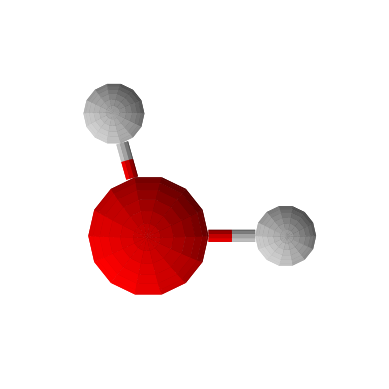

In [15]:
render_system(
        initialized_structure_H2O,
        centerer=lambda system: system.atoms[0].point,
        aligner=lambda system: (system.atoms[1].point, system.atoms[2].point)
)

## 2.2.x Geometry Minimization

That guess is looking a little rough, lets optimize it using electronic structure theory. While the PEF will be developed at the CCSD(T) level of theory, its not important that the geometry optimization be at the same level of theory as the reference energies will be calculated at, so lets use something cheaper like a high-quality DFT functional.

In [16]:
calculator = Psi4Calculator(
        "MP2",
        "def2-TZVP",
        log_directory=paths.logs,
        scratch_directory=paths.scratch.psi4
)

In [17]:
minimized_structure_CH3NH2, minimized_energy_CH3NH2 = minimize_structure(
        initialized_structure_CH3NH2,
        calculator=calculator,
        restart_path=paths.restart.minimization_CH3NH2,
        num_threads=16,
        mem_mb=32000
)
write_system_and_energy(paths.structures.minimized_CH3NH2, (minimized_structure_CH3NH2, minimized_energy_CH3NH2))

Minimizing geometries:  |====================================================================================================| - 1/1
Completed geometry minimizations!


In [18]:
minimized_structure_H2O, minimized_energy_H2O = minimize_structure(
        initialized_structure_H2O,
        calculator=calculator,
        restart_path=paths.restart.minimization_H2O,
        num_threads=16,
        mem_mb=32000
)
write_system_and_energy(paths.structures.minimized_H2O, (minimized_structure_H2O, minimized_energy_H2O))

Minimizing geometries:  |====================================================================================================| - 1/1
Completed geometry minimizations!


Plotting

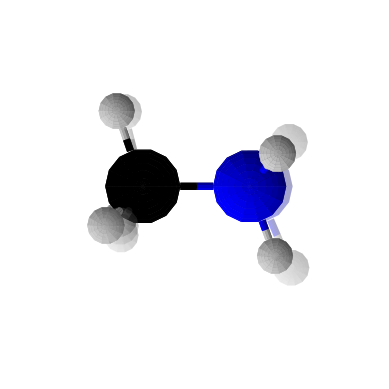

In [19]:
render_overlayed_systems(
    [initialized_structure_CH3NH2, minimized_structure_CH3NH2],
    centerer=lambda system: system.atoms[0].point,
    aligner=lambda system: (system.atoms[4].point, system.atoms[3].point),
    alpha=(0.2, 1.0)
)

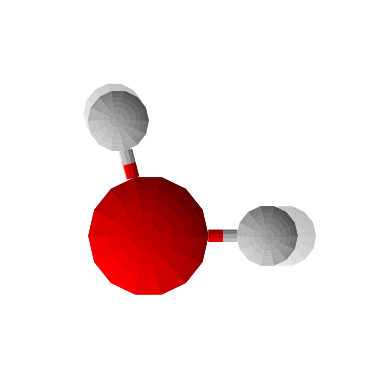

In [20]:
render_overlayed_systems(
    [initialized_structure_H2O, minimized_structure_H2O],
    centerer=lambda system: system.atoms[0].point,
    aligner=lambda system: (system.atoms[1].point, system.atoms[2].point),
    alpha=(0.2, 1.0)
)

In [21]:
vibrational_modes_CH3NH2 = calculate_vibrational_modes(
        minimized_structure_CH3NH2,
        calculator,
        paths.restart.vibrational_modes_CH3NH2,
        16,
        32000
)
write_vibrational_modes(paths.structures.vibrational_modes_CH3NH2, vibrational_modes_CH3NH2)

Calculating vibrational modes:  |====================================================================================================| - 1/1
Completed vibrational mode calculations!


In [22]:
vibrational_modes_H2O = calculate_vibrational_modes(
        minimized_structure_H2O,
        calculator,
        paths.restart.vibrational_modes_H2O,
        16,
        32000
)
write_vibrational_modes(paths.structures.vibrational_modes_H2O, vibrational_modes_H2O)

Calculating vibrational modes:  |====================================================================================================| - 1/1
Completed vibrational mode calculations!


## 2.2.2 Two-Body Scans

Now we make a few two-body scans. We will use these during future steps to validate the quality of the 2-body parts of the PEF.

Lets generate a few 2-body CH$_3$-NH$_2$ -- H$_2$O scans. We will make three scans.

In [23]:
dimer_CH3NH2_H2O = BasicCompound(definition_CH3NH2_H2O)

dimer_CH3NH2_H2O.fragments[0].set_xyz(paths.structures.minimized_CH3NH2)
dimer_CH3NH2_H2O.fragments[1].set_xyz(paths.structures.minimized_H2O)

monomer_CH3NH2 = dimer_CH3NH2_H2O.fragments[0]
monomer_H2O = dimer_CH3NH2_H2O.fragments[1]

H-bond between H on -NH$_2$ and O in H$_2$O:

In [24]:
scan_CH3NH2_H2O_1 = make_scan(
        system=dimer_CH3NH2_H2O,
        region1=monomer_CH3NH2,
        region2=monomer_H2O,
        center1=monomer_CH3NH2.atoms[5].point,
        center2=monomer_H2O.atoms[0].point,
        align1=[monomer_CH3NH2.atoms[5].point-monomer_CH3NH2.atoms[4].point, monomer_CH3NH2.atoms[5].point-monomer_CH3NH2.atoms[0].point],
        align2=[monomer_H2O.atoms[1].point-monomer_H2O.atoms[0].point + monomer_H2O.atoms[2].point-monomer_H2O.atoms[0].point, monomer_H2O.atoms[1].point - monomer_H2O.atoms[0].point],
        distances=numpy.arange(1.0, 10.5, 0.5)
)

write_systems(paths.scans.CH3NH2_H2O.first, scan_CH3NH2_H2O_1)

In [25]:
HTML(render_systems(
        scan_CH3NH2_H2O_1,
        centerer=lambda system: system.atoms[4].point,
        aligner=lambda system: (system.atoms[7].point, system.atoms[0].point)
).to_jshtml())

H-bond between H on H$_2$O and N in -NH$_2$:

In [26]:
scan_CH3NH2_H2O_2 = make_scan(
        system=dimer_CH3NH2_H2O,
        region1=monomer_CH3NH2,
        region2=monomer_H2O,
        center1=monomer_CH3NH2.atoms[4].point,
        center2=monomer_H2O.atoms[1].point,
        align1=(monomer_CH3NH2.atoms[4].point-monomer_CH3NH2.atoms[0].point + monomer_CH3NH2.atoms[4].point-monomer_CH3NH2.atoms[5].point + monomer_CH3NH2.atoms[4].point-monomer_CH3NH2.atoms[6].point, monomer_CH3NH2.atoms[0].point-monomer_CH3NH2.atoms[4].point),
        align2=(monomer_H2O.atoms[0].point-monomer_H2O.atoms[1].point, monomer_H2O.atoms[2].point-monomer_H2O.atoms[1].point),
        distances=numpy.arange(1.0, 10.5, 0.5)
)

write_systems(paths.scans.CH3NH2_H2O.second, scan_CH3NH2_H2O_2)

In [27]:
HTML(render_systems(
        scan_CH3NH2_H2O_2,
        centerer=lambda system: system.atoms[4].point,
        aligner=lambda system: (system.atoms[7].point, system.atoms[0].point)
).to_jshtml())

H from -CH$_3$ approaching O in H$_2$O

In [28]:
scan_CH3NH2_H2O_3 = make_scan(
        system=dimer_CH3NH2_H2O,
        region1=monomer_CH3NH2,
        region2=monomer_H2O,
        center1=monomer_CH3NH2.atoms[1].point,
        center2=monomer_H2O.atoms[0].point,
        align1=(monomer_CH3NH2.atoms[1].point-monomer_CH3NH2.atoms[0].point, monomer_CH3NH2.atoms[4].point-monomer_CH3NH2.atoms[1].point),
        align2=(monomer_H2O.atoms[1].point-monomer_H2O.atoms[0].point + monomer_H2O.atoms[2].point-monomer_H2O.atoms[0].point, monomer_H2O.atoms[1].point-monomer_H2O.atoms[0].point),
        distances=numpy.arange(1.0, 10.5, 0.5)
)

write_systems(paths.scans.CH3NH2_H2O.third, scan_CH3NH2_H2O_3)

In [29]:
HTML(render_systems(
        scan_CH3NH2_H2O_3,
        centerer=lambda system: system.atoms[0].point,
        aligner=lambda system: (system.atoms[7].point, system.atoms[4].point)
).to_jshtml())

Now, lets perform the reference calculations for the scans.

In [30]:
scan_CH3NH2_H2O_1_energies = calculate_nmer_energies(
        scan_CH3NH2_H2O_1,
        calculator,
        paths.restart.scans_CH3NH2_H2O_1_energies,
        num_threads=8,
        mem_mb=8000
)
write_systems_and_nmer_energies(paths.scans.CH3NH2_H2O.first_energies, (scan_CH3NH2_H2O_1, scan_CH3NH2_H2O_1_energies))

Running energy calculations |====================================================================================================| - 57/57
Completed n-mer energy calculations!


In [31]:
scan_CH3NH2_H2O_2_energies = calculate_nmer_energies(
        scan_CH3NH2_H2O_2,
        calculator,
        paths.restart.scans_CH3NH2_H2O_2_energies,
        num_threads=8,
        mem_mb=8000
)
write_systems_and_nmer_energies(paths.scans.CH3NH2_H2O.second_energies, (scan_CH3NH2_H2O_2, scan_CH3NH2_H2O_2_energies))

Running energy calculations |====================================================================================================| - 57/57
Completed n-mer energy calculations!


In [32]:
scan_CH3NH2_H2O_3_energies = calculate_nmer_energies(
        scan_CH3NH2_H2O_3,
        calculator,
        paths.restart.scans_CH3NH2_H2O_3_energies,
        num_threads=8,
        mem_mb=8000
)
write_systems_and_nmer_energies(paths.scans.CH3NH2_H2O.third_energies, (scan_CH3NH2_H2O_3, scan_CH3NH2_H2O_3_energies))

Running energy calculations |====================================================================================================| - 57/57
Completed n-mer energy calculations!


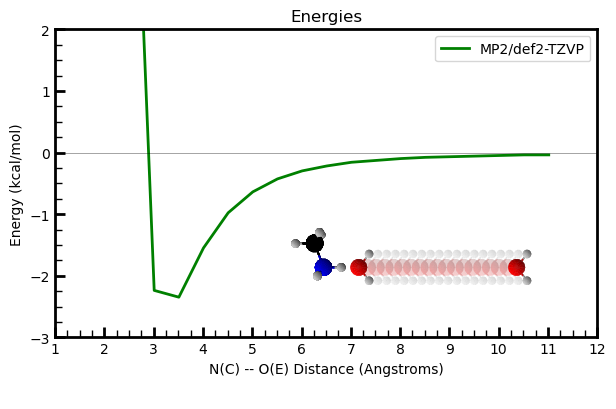

In [33]:
scan_CH3NH2_H2O_1_2b_energies = calculate_many_body_energies(scan_CH3NH2_H2O_1, scan_CH3NH2_H2O_1_energies)

plot_scan(
        scan_CH3NH2_H2O_1,
        {"MP2/def2-TZVP": scan_CH3NH2_H2O_1_2b_energies},
        4,
        7,
        title="Energies",
        ymax=2,
        centerer=lambda system: system.atoms[4].point,
        aligner=lambda system: (system.atoms[7].point, system.atoms[0].point)
)

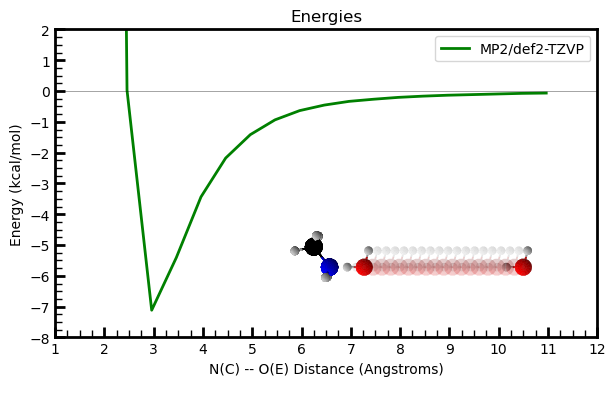

In [34]:
scan_CH3NH2_H2O_2_2b_energies = calculate_many_body_energies(scan_CH3NH2_H2O_2, scan_CH3NH2_H2O_2_energies)

plot_scan(
        scan_CH3NH2_H2O_2,
        {"MP2/def2-TZVP": scan_CH3NH2_H2O_2_2b_energies},
        4,
        7,
        title="Energies",
        ymax=2,
        centerer=lambda system: system.atoms[4].point,
        aligner=lambda system: (system.atoms[7].point, system.atoms[0].point)
)

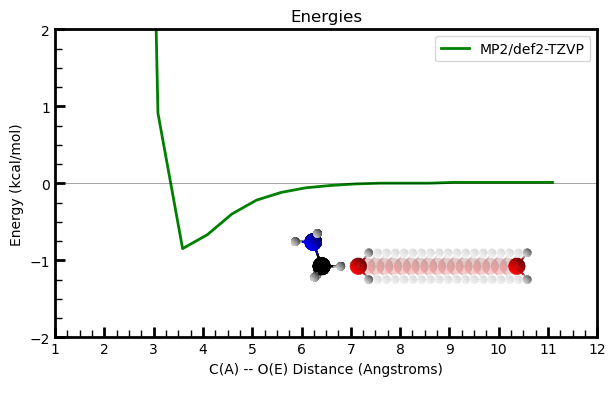

In [35]:
scan_CH3NH2_H2O_3_2b_energies = calculate_many_body_energies(scan_CH3NH2_H2O_3, scan_CH3NH2_H2O_3_energies)

plot_scan(
        scan_CH3NH2_H2O_3,
        {"MP2/def2-TZVP": scan_CH3NH2_H2O_3_2b_energies},
        0,
        7,
        title="Energies",
        ymax=2,
        centerer=lambda system: system.atoms[0].point,
        aligner=lambda system: (system.atoms[7].point, system.atoms[4].point)
)

## 2.2.3 Three-Body Scans

Now we make a few three-body scans. We will use these during future steps to validate the quality of the 2-body parts of the PEF.

Lets also consider a few 3-body structures. We will make three scans.

In [36]:
trimer_CH3NH2_H2O_H2O = BasicCompound(definition_CH3NH2_H2O_H2O)

trimer_CH3NH2_H2O_H2O.fragments[0].set_xyz(paths.structures.minimized_CH3NH2)
trimer_CH3NH2_H2O_H2O.fragments[1].set_xyz(paths.structures.minimized_H2O)
trimer_CH3NH2_H2O_H2O.fragments[2].set_xyz(paths.structures.minimized_H2O)

monomer_CH3NH2 = trimer_CH3NH2_H2O_H2O.fragments[0]
monomer_H2O_1 = trimer_CH3NH2_H2O_H2O.fragments[1]
monomer_H2O_2 = trimer_CH3NH2_H2O_H2O.fragments[2]

region_CH3NH2_H2O = BasicMutableRegionManager(trimer_CH3NH2_H2O_H2O).make_region([monomer_CH3NH2, monomer_H2O_1])
transformer_CH3NH2 = SystemTransformer(monomer_CH3NH2)
transformer_H2O_1 = SystemTransformer(monomer_H2O_1)

-NH$_2$ donating 2 H-bonds to 2 H$_2$Os, where one H$_2$O moves away:

In [37]:
transformer_CH3NH2.translate(translation=-monomer_CH3NH2.atoms[5].point)
transformer_H2O_1.translate(translation=-monomer_H2O_1.atoms[0].point)
transformer_CH3NH2.align(vectors_to_align=[-monomer_CH3NH2.atoms[4].point, monomer_CH3NH2.atoms[0].point])
transformer_H2O_1.align(vectors_to_align=[monomer_H2O_1.atoms[1].point + monomer_H2O_1.atoms[2].point, monomer_H2O_1.atoms[1].point])

# Make fixed H-bond 2.0 A long
transformer_H2O_1.translate(x=2.0)

scan_CH3NH2_H2O_H2O_1 = make_scan(
        system=trimer_CH3NH2_H2O_H2O,
        region1=region_CH3NH2_H2O,
        region2=monomer_H2O_2,
        center1=monomer_CH3NH2.atoms[6].point,
        center2=monomer_H2O_2.atoms[0].point,
        align1=[monomer_CH3NH2.atoms[6].point-monomer_CH3NH2.atoms[4].point, monomer_CH3NH2.atoms[6].point-monomer_CH3NH2.atoms[0].point],
        align2=[monomer_H2O_2.atoms[1].point-monomer_H2O_2.atoms[0].point + monomer_H2O_2.atoms[2].point-monomer_H2O_2.atoms[0].point, monomer_H2O_2.atoms[1].point - monomer_H2O_2.atoms[0].point],
        distances=numpy.arange(1.0, 10.5, 0.5)
)

write_systems(paths.scans.CH3NH2_H2O_H2O.first, scan_CH3NH2_H2O_H2O_1)

In [38]:
HTML(render_systems(
        scan_CH3NH2_H2O_H2O_1,
        centerer=lambda system: system.atoms[4].point,
        aligner=lambda system: (system.atoms[-3].point, system.atoms[0].point)
).to_jshtml())

-NH$_2$ donating 1 H-bond and accepting 1 H-bond, where the H$_2$O that is accepting an H-bond moves away.

In [39]:
transformer_CH3NH2.translate(translation=-monomer_CH3NH2.atoms[4].point)
transformer_H2O_1.translate(translation=-monomer_H2O_1.atoms[1].point)
transformer_CH3NH2.align(vectors_to_align=[-monomer_CH3NH2.atoms[5].point-monomer_CH3NH2.atoms[6].point-monomer_CH3NH2.atoms[0].point, monomer_CH3NH2.atoms[0].point])
transformer_H2O_1.align(vectors_to_align=[monomer_H2O_1.atoms[0].point, monomer_H2O_1.atoms[2].point])

# Make fixed H-bond 2.0 A long
transformer_H2O_1.translate(x=2.0)

scan_CH3NH2_H2O_H2O_2 = make_scan(
        system=trimer_CH3NH2_H2O_H2O,
        region1=region_CH3NH2_H2O,
        region2=monomer_H2O_2,
        center1=monomer_CH3NH2.atoms[6].point,
        center2=monomer_H2O_2.atoms[0].point,
        align1=[monomer_CH3NH2.atoms[6].point-monomer_CH3NH2.atoms[4].point, monomer_CH3NH2.atoms[6].point-monomer_CH3NH2.atoms[0].point],
        align2=[monomer_H2O_2.atoms[1].point-monomer_H2O_2.atoms[0].point + monomer_H2O_2.atoms[2].point-monomer_H2O_2.atoms[0].point, monomer_H2O_2.atoms[1].point - monomer_H2O_2.atoms[0].point],
        distances=numpy.arange(1.0, 10.5, 0.5)
)

write_systems(paths.scans.CH3NH2_H2O_H2O.second, scan_CH3NH2_H2O_H2O_2)

In [40]:
HTML(render_systems(
        scan_CH3NH2_H2O_H2O_2,
        centerer=lambda system: system.atoms[4].point,
        aligner=lambda system: (system.atoms[-3].point, system.atoms[0].point)
).to_jshtml())

-NH$_2$ donating 1 H-bond and accepting 1 H-bond, where the H$_2$O that is donating an H-bond moves away.

In [41]:
transformer_CH3NH2.translate(translation=-monomer_CH3NH2.atoms[5].point)
transformer_H2O_1.translate(translation=-monomer_H2O_1.atoms[0].point)
transformer_CH3NH2.align(vectors_to_align=[-monomer_CH3NH2.atoms[4].point, monomer_CH3NH2.atoms[0].point])
transformer_H2O_1.align(vectors_to_align=[monomer_H2O_1.atoms[1].point + monomer_H2O_1.atoms[2].point, monomer_H2O_1.atoms[1].point])

# Make fixed H-bond 2.0 A long
transformer_H2O_1.translate(x=2.0)

scan_CH3NH2_H2O_H2O_3 = make_scan(
        system=trimer_CH3NH2_H2O_H2O,
        region1=region_CH3NH2_H2O,
        region2=monomer_H2O_2,
        center1=monomer_CH3NH2.atoms[4].point,
        center2=monomer_H2O_2.atoms[1].point,
        align1=[monomer_CH3NH2.atoms[4].point-monomer_CH3NH2.atoms[5].point + monomer_CH3NH2.atoms[4].point-monomer_CH3NH2.atoms[6].point + monomer_CH3NH2.atoms[4].point-monomer_CH3NH2.atoms[0].point, monomer_CH3NH2.atoms[4].point-monomer_CH3NH2.atoms[0].point],
        align2=[monomer_H2O_2.atoms[0].point-monomer_H2O_2.atoms[1].point, monomer_H2O_2.atoms[2].point - monomer_H2O_2.atoms[0].point],
        distances=numpy.arange(1.0, 10.5, 0.5)
)

write_systems(paths.scans.CH3NH2_H2O_H2O.third, scan_CH3NH2_H2O_H2O_3)

In [42]:
HTML(render_systems(
        scan_CH3NH2_H2O_H2O_3,
        centerer=lambda system: system.atoms[4].point,
        aligner=lambda system: (system.atoms[-3].point, system.atoms[0].point)
).to_jshtml())

In [43]:
scan_CH3NH2_H2O_H2O_1_energies = calculate_nmer_energies(
        scan_CH3NH2_H2O_H2O_1,
        calculator,
        paths.restart.scans_CH3NH2_H2O_H2O_1_energies,
        num_threads=16,
        mem_mb=32000
)
write_systems_and_nmer_energies(paths.scans.CH3NH2_H2O_H2O.first_energies, (scan_CH3NH2_H2O_H2O_1, scan_CH3NH2_H2O_H2O_1_energies))

Running energy calculations |====================================================================================================| - 133/133
Completed n-mer energy calculations!


In [44]:
scan_CH3NH2_H2O_H2O_2_energies = calculate_nmer_energies(
        scan_CH3NH2_H2O_H2O_2,
        calculator,
        paths.restart.scans_CH3NH2_H2O_H2O_2_energies,
        num_threads=16,
        mem_mb=32000
)
write_systems_and_nmer_energies(paths.scans.CH3NH2_H2O_H2O.second_energies, (scan_CH3NH2_H2O_H2O_2, scan_CH3NH2_H2O_H2O_2_energies))

Running energy calculations |====================================================================================================| - 133/133
Completed n-mer energy calculations!


In [45]:
scan_CH3NH2_H2O_H2O_3_energies = calculate_nmer_energies(
        scan_CH3NH2_H2O_H2O_3,
        calculator,
        paths.restart.scans_CH3NH2_H2O_H2O_3_energies,
        num_threads=16,
        mem_mb=32000
)
write_systems_and_nmer_energies(paths.scans.CH3NH2_H2O_H2O.third_energies, (scan_CH3NH2_H2O_H2O_3, scan_CH3NH2_H2O_H2O_3_energies))

Running energy calculations |====================================================================================================| - 133/133
Completed n-mer energy calculations!


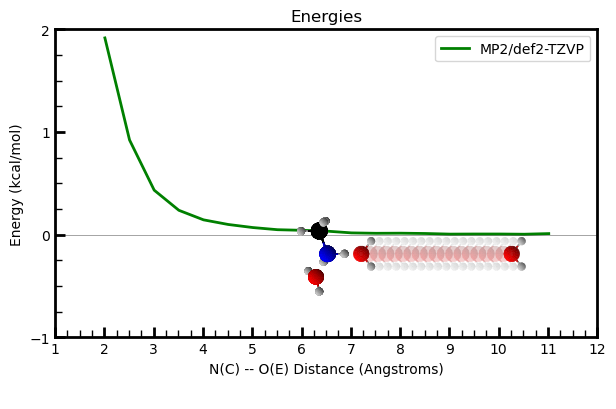

In [46]:
scan_CH3NH2_H2O_H2O_1_3b_energies = calculate_many_body_energies(scan_CH3NH2_H2O_H2O_1, scan_CH3NH2_H2O_H2O_1_energies)

plot_scan(
        scan_CH3NH2_H2O_H2O_1,
        {"MP2/def2-TZVP": scan_CH3NH2_H2O_H2O_1_3b_energies},
        4,
        -3,
        title="Energies",
        ymax=2,
        centerer=lambda system: system.atoms[4].point,
        aligner=lambda system: (system.atoms[10].point, system.atoms[0].point)
)

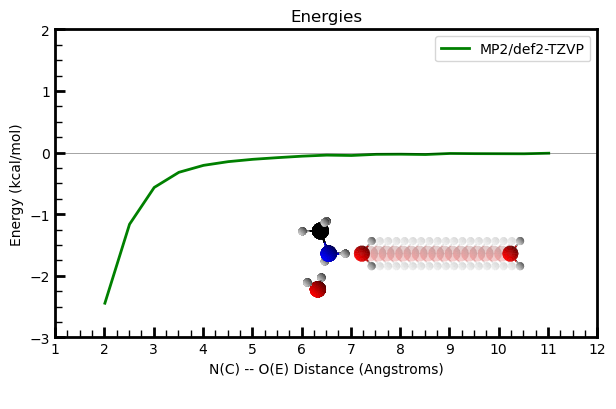

In [47]:
scan_CH3NH2_H2O_H2O_2_3b_energies = calculate_many_body_energies(scan_CH3NH2_H2O_H2O_2, scan_CH3NH2_H2O_H2O_2_energies)

plot_scan(
        scan_CH3NH2_H2O_H2O_2,
        {"MP2/def2-TZVP": scan_CH3NH2_H2O_H2O_2_3b_energies},
        4,
        -3,
        title="Energies",
        ymax=2,
        centerer=lambda system: system.atoms[4].point,
        aligner=lambda system: (system.atoms[10].point, system.atoms[0].point)
)

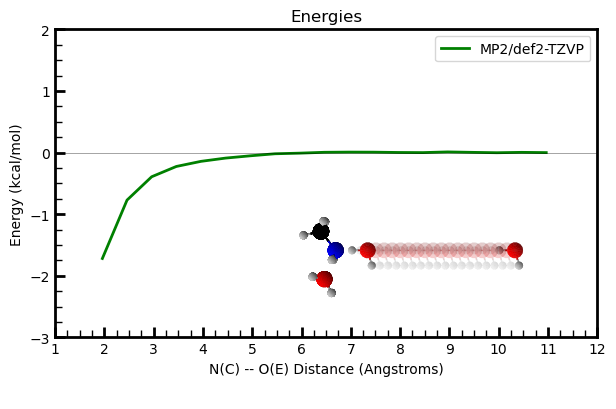

In [48]:
scan_CH3NH2_H2O_H2O_3_3b_energies = calculate_many_body_energies(scan_CH3NH2_H2O_H2O_3, scan_CH3NH2_H2O_H2O_3_energies)

plot_scan(
        scan_CH3NH2_H2O_H2O_3,
        {"MP2/def2-TZVP": scan_CH3NH2_H2O_H2O_3_3b_energies},
        4,
        -3,
        title="Energies",
        ymax=2,
        centerer=lambda system: system.atoms[4].point,
        aligner=lambda system: (system.atoms[-3].point, system.atoms[0].point)
)

## 2.x.y Clusters

In [1]:
cluster_optimizer = 
Psi4Calculator(
        "HF",
        "STO-3G",
        log_directory=paths.logs,
        scratch_directory=paths.scratch.psi4,
        qm_options={
            "GEOM_MAXITER": 500,
            "intrafrag_step_limit_max": 0.25
        }
)

SyntaxError: invalid syntax (2942901155.py, line 1)

In [50]:
clusters_CH3NH2_H2O = find_clusters(
        [minimized_structure_CH3NH2, minimized_structure_H2O],
        calculator=cluster_optimizer,
        num_guesses=20,
        restart_path=paths.restart.clusters_CH3NH2_H2O,
        guess_seed=123345,
        radius=5,
        num_threads=16,
        mem_mb=32000,
        similarity_threshold=0.1,
        filter_by_hbonds=True,
        hbond_cut=3.0
)
write_systems(paths.clusters.CH3NH2_H2O, clusters_CH3NH2_H2O)

Distance Distribution: dist (A) = 5.0 * x + 0.0 for x in range [0,1].
Beginning random distance and rotation configuration generation.
Will generate 20 configs with distance distribution dist (A) = 5.0 * x + 0.0 for x in range [0,1].
Done! Generated 20 configurations.
Minimizing geometries:  |====================================================================================================| - 20/20
Completed geometry minimizations!
Finding unique clusters:  |====================================================================================================| - 20/20
Found 3 unique minimized clusters.


In [51]:
HTML(render_systems(
        clusters_CH3NH2_H2O,
        centerer=lambda system: system.atoms[0].point,
        aligner=lambda system: (system.atoms[4].point, system.atoms[1].point)
).to_jshtml())

In [52]:
clusters_CH3NH2_H2O_H2O = find_clusters(
        [minimized_structure_CH3NH2, minimized_structure_H2O, minimized_structure_H2O],
        calculator=cluster_optimizer,
        num_guesses=20,
        restart_path=paths.restart.clusters_CH3NH2_H2O_H2O,
        guess_seed=123345,
        radius=5,
        num_threads=16,
        mem_mb=32000,
        similarity_threshold=0.1,
        filter_by_hbonds=True,
        hbond_cut=2.5
)
write_systems(paths.clusters.CH3NH2_H2O_H2O, clusters_CH3NH2_H2O_H2O)

Distance Distribution: dist (A) = 5.0 * x + 0.0 for x in range [0,1].
Beginning random distance and rotation configuration generation.
Will generate 20 configs with distance distribution dist (A) = 5.0 * x + 0.0 for x in range [0,1].
Done! Generated 20 configurations.
Minimizing geometries:  |====================================================================================================| - 20/20
Completed geometry minimizations!
Finding unique clusters:  |====================================================================================================| - 20/20
Found 9 unique minimized clusters.


In [53]:
HTML(render_systems(
        clusters_CH3NH2_H2O_H2O,
        centerer=lambda system: system.atoms[0].point,
        aligner=lambda system: (system.atoms[4].point, system.atoms[1].point)
).to_jshtml())

In [54]:
clusters_tetramer = find_clusters(
        [minimized_structure_CH3NH2, minimized_structure_H2O, minimized_structure_H2O, minimized_structure_H2O],
        calculator=cluster_optimizer,
        num_guesses=20,
        restart_path=paths.restart.clusters_tetramer,
        guess_seed=123345,
        radius=5,
        num_threads=16,
        mem_mb=32000,
        similarity_threshold=1,
        filter_by_hbonds=True,
        hbond_cut=3.0
)
write_systems(paths.clusters.tetramer, clusters_tetramer)

Distance Distribution: dist (A) = 5.0 * x + 0.0 for x in range [0,1].
Beginning random distance and rotation configuration generation.
Will generate 20 configs with distance distribution dist (A) = 5.0 * x + 0.0 for x in range [0,1].
Done! Generated 20 configurations.
Minimizing geometries:  |====================================================================================================| - 20/20
Completed geometry minimizations!
Finding unique clusters:  |====================================================================================================| - 20/20
Found 11 unique minimized clusters.


In [56]:
HTML(render_systems(
        clusters_tetramer,
        centerer=lambda system: system.atoms[0].point,
        aligner=lambda system: (system.atoms[4].point, system.atoms[1].point)
).to_jshtml())

In [57]:
clusters_pentamer = find_clusters(
        [minimized_structure_CH3NH2, minimized_structure_H2O, minimized_structure_H2O, minimized_structure_H2O, minimized_structure_H2O],
        calculator=cluster_optimizer,
        num_guesses=10,
        restart_path=paths.restart.clusters_pentamer,
        guess_seed=123345,
        radius=5,
        num_threads=16,
        mem_mb=32000,
        similarity_threshold=0.1,
        filter_by_hbonds=True,
        hbond_cut=3.0
)
write_systems(paths.clusters.pentamer, clusters_pentamer)

Distance Distribution: dist (A) = 5.0 * x + 0.0 for x in range [0,1].
Beginning random distance and rotation configuration generation.
Will generate 10 configs with distance distribution dist (A) = 5.0 * x + 0.0 for x in range [0,1].
Done! Generated 10 configurations.
Minimizing geometries:  |====================================================================================================| - 10/10
Completed geometry minimizations!
Finding unique clusters:  |====================================================================================================| - 10/10
Found 9 unique minimized clusters.


In [58]:
HTML(render_systems(
        clusters_pentamer,
        centerer=lambda system: system.atoms[0].point,
        aligner=lambda system: (system.atoms[4].point, system.atoms[1].point)
).to_jshtml())

In [59]:
clusters_CH3NH2_H2O_energies = calculate_nmer_energies(
        clusters_CH3NH2_H2O,
        calculator,
        paths.restart.clusters_CH3NH2_H2O_energies,
        num_threads=16,
        mem_mb=32000
)

write_systems_and_nmer_energies(paths.clusters.CH3NH2_H2O_energies, (clusters_CH3NH2_H2O, clusters_CH3NH2_H2O_energies))

Running energy calculations |====================================================================================================| - 9/9
Completed n-mer energy calculations!


In [60]:
clusters_CH3NH2_H2O_H2O_energies = calculate_nmer_energies(
        clusters_CH3NH2_H2O_H2O,
        calculator,
        paths.restart.clusters_CH3NH2_H2O_H2O_energies,
        num_threads=16,
        mem_mb=32000
)

write_systems_and_nmer_energies(paths.clusters.CH3NH2_H2O_H2O_energies, (clusters_CH3NH2_H2O_H2O, clusters_CH3NH2_H2O_H2O_energies))

Running energy calculations |====================================================================================================| - 63/63
Completed n-mer energy calculations!


In [61]:
clusters_tetramer_energies = calculate_nmer_energies(
        clusters_tetramer,
        calculator,
        paths.restart.clusters_tetramer_energies,
        num_threads=16,
        mem_mb=32000
)

write_systems_and_nmer_energies(paths.clusters.tetramer_energies, (clusters_tetramer, clusters_tetramer_energies))

Running energy calculations |====================================================================================================| - 165/165
Completed n-mer energy calculations!


In [62]:
clusters_pentamer_energies = calculate_nmer_energies(
        clusters_pentamer,
        calculator,
        paths.restart.clusters_pentamer_energies,
        num_threads=16,
        mem_mb=32000
)

write_systems_and_nmer_energies(paths.clusters.pentamer_energies, (clusters_pentamer, clusters_pentamer_energies))

Running energy calculations |====================================================================================================| - 279/279
Completed n-mer energy calculations!


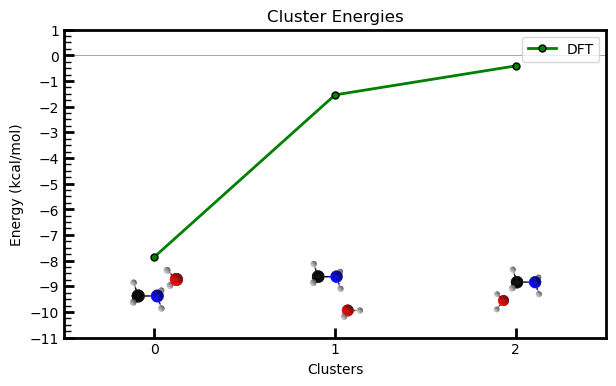

In [63]:
plot_clusters(
        clusters_CH3NH2_H2O,
        {
            "DFT": calculate_many_body_energies(clusters_CH3NH2_H2O, clusters_CH3NH2_H2O_energies)
        },
        centerer=lambda system: system.atoms[0].point,
        aligner=lambda system: (system.atoms[4].point, system.atoms[1].point),
        ymin=-11,
        render_scale=0.3
)

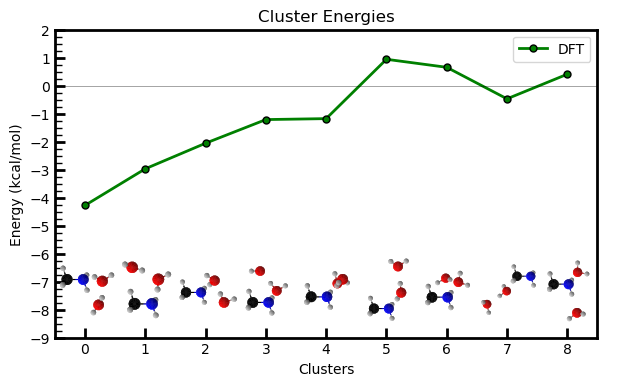

In [64]:
plot_clusters(
        clusters_CH3NH2_H2O_H2O,
        {
            "DFT": calculate_many_body_energies(clusters_CH3NH2_H2O_H2O, clusters_CH3NH2_H2O_H2O_energies)
        },
        centerer=lambda system: system.atoms[0].point,
        aligner=lambda system: (system.atoms[4].point, system.atoms[1].point),
        ymin=-9,
        render_scale=0.3
)

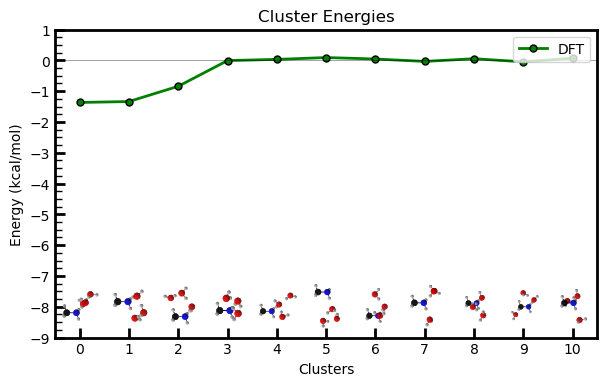

In [65]:
plot_clusters(
        clusters_tetramer,
        {
            "DFT": calculate_many_body_energies(clusters_tetramer, clusters_tetramer_energies)
        },
        centerer=lambda system: system.atoms[0].point,
        aligner=lambda system: (system.atoms[4].point, system.atoms[1].point),
        ymin=-9,
        render_scale=0.2
)

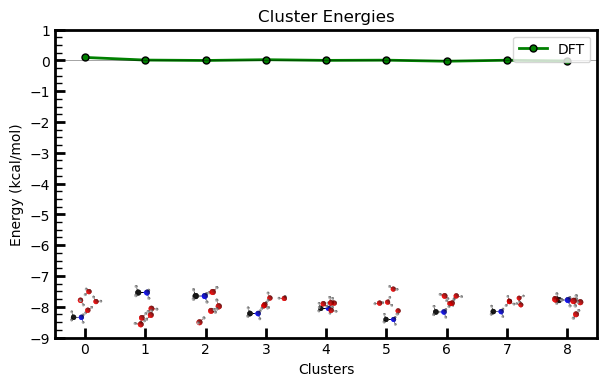

In [66]:
plot_clusters(
        clusters_pentamer,
        {
            "DFT": calculate_many_body_energies(clusters_pentamer, clusters_pentamer_energies)
        },
        centerer=lambda system: system.atoms[0].point,
        aligner=lambda system: (system.atoms[4].point, system.atoms[1].point),
        ymin=-9,
        render_scale=0.2
)

In [67]:
vibrational_modes_clusters_CH3NH2_H2O = calculate_vibrational_modes(
        clusters_CH3NH2_H2O,
        cluster_optimizer,
        paths.restart.clusters_CH3NH2_H2O_modes,
        16,
        32000
)
write_multiple_vibrational_modes(paths.clusters.CH3NH2_H2O_modes, vibrational_modes_clusters_CH3NH2_H2O)

Calculating vibrational modes:  |====================================================================================================| - 3/3
Completed vibrational mode calculations!


In [68]:
vibrational_modes_clusters_CH3NH2_H2O_H2O = calculate_vibrational_modes(
        clusters_CH3NH2_H2O_H2O,
        cluster_optimizer,
        paths.restart.clusters_CH3NH2_H2O_H2O_modes,
        16,
        32000
)
write_multiple_vibrational_modes(paths.clusters.CH3NH2_H2O_H2O_modes, vibrational_modes_clusters_CH3NH2_H2O_H2O)

Calculating vibrational modes:  |====================================================================================================| - 9/9
Completed vibrational mode calculations!
